In [237]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [238]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [239]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [240]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [241]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

In [242]:
def get_discount_matrix(size):
    a = np.arange(size)
    a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    np.fill_diagonal(a, 0)

    return a

In [243]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [244]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


In [245]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)
# np.fill_diagonal(NW, 0)
print('W', W.shape, W.max(), W.min(), np.median(W))

iter_cnt = 100

eps0 = 0.01
eps = eps0

for img in images[:1]:
    I = np.copy(img)
    print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

    # print(img)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        # eps = (iter_cnt - iter_idx) * eps0

        # infer
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)
        
        # O = O ** 2
        print(f'{np.max(O)=}')

        # inhibition
        NrmO = O / np.max(O)
        NDO = np.exp((NrmO - NW)**2 * -20.0)
        np.fill_diagonal(NDO, 0)
        # NDO = NDO ** 2
        O -= np.sum(NDO, axis=1) * 1.0
        print(f'{np.max(O)=} {np.max(NDO)=}')

        # inh train
        dNW = (NrmO - NW) * eps
        dNW[np.where(O <= 0)] = 0

        # inh update
        # NW += dNW
        # np.fill_diagonal(NW, 0)

        # train
        dW = (I - W) * eps
        dW[np.where(O <= 0)] = 0

        # update
        W += dW

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        t = np.sum(O > 0)
        T.append(t)

        OST.append(np.copy(O))

print('W', W.shape, W.max(), W.min(), np.median(W))

W (784, 784) 0.999997563915488 8.433436723409571e-07 0.5000809354237206
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
np.max(O)=197.72864088024207
np.max(O)=-28.67875366559562 np.max(NDO)=0.9999999999803844
np.max(O)=5.025684242900926
np.max(O)=-273.5689924606611 np.max(NDO)=0.9999999999915647
np.max(O)=100.33531876588259
np.max(O)=-153.02306751037912 np.max(NDO)=0.999999999958836
np.max(O)=43.72986595322411
np.max(O)=-211.3972003308799 np.max(NDO)=0.9999999999800736
np.max(O)=66.10307098393959
np.max(O)=-186.87252084741263 np.max(NDO)=0.9999999999846106
np.max(O)=54.68915995053161
np.max(O)=-198.30564656188358 np.max(NDO)=0.9999999999003755
np.max(O)=59.6227879570239
np.max(O)=-193.86337656939045 np.max(NDO)=0.9999999999999779
np.max(O)=57.71318831452892
np.max(O)=-195.5448110621514 np.max(NDO)=0.9999999999537815
np.max(O)=58.45333570836941
np.max(O)=-194.94270338191598 np.max(NDO)=0.9999999999994063
np.max(O)=58.19585430373542
np.max(O)=-195.13756861511987 np.max(NDO)=0.999

- TODO: Train and Test.

T[-1]=784


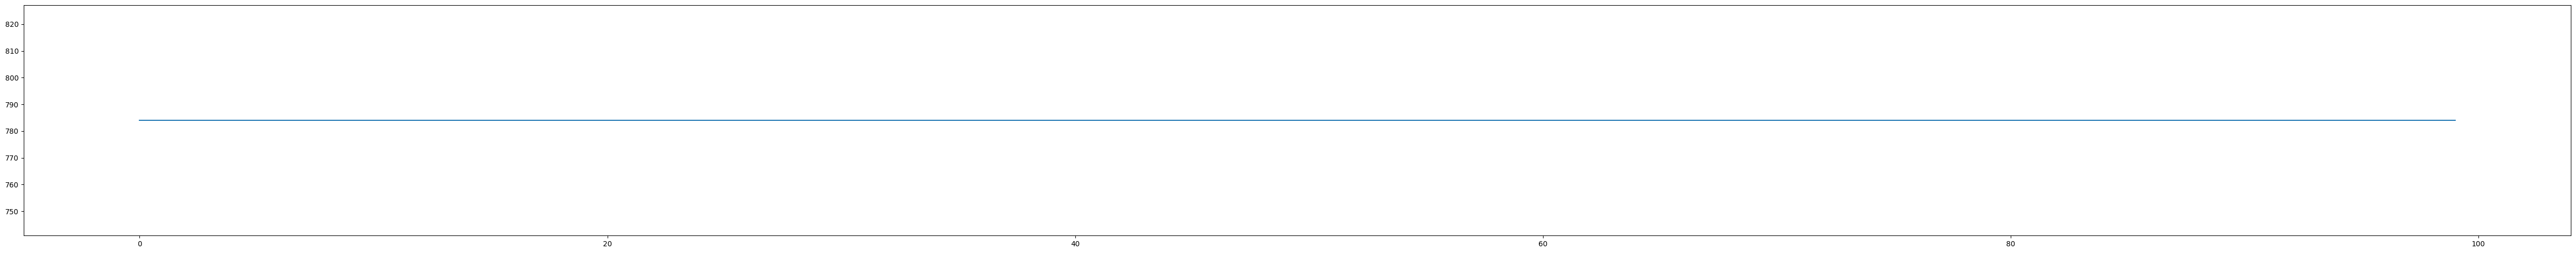

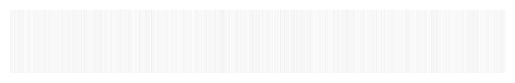

In [246]:
print(f'{T[-1]=}')
simple_plot(T=T)

show_image(image=OST, cmap='Greys')

i_T[-1]=0.3955214478197864


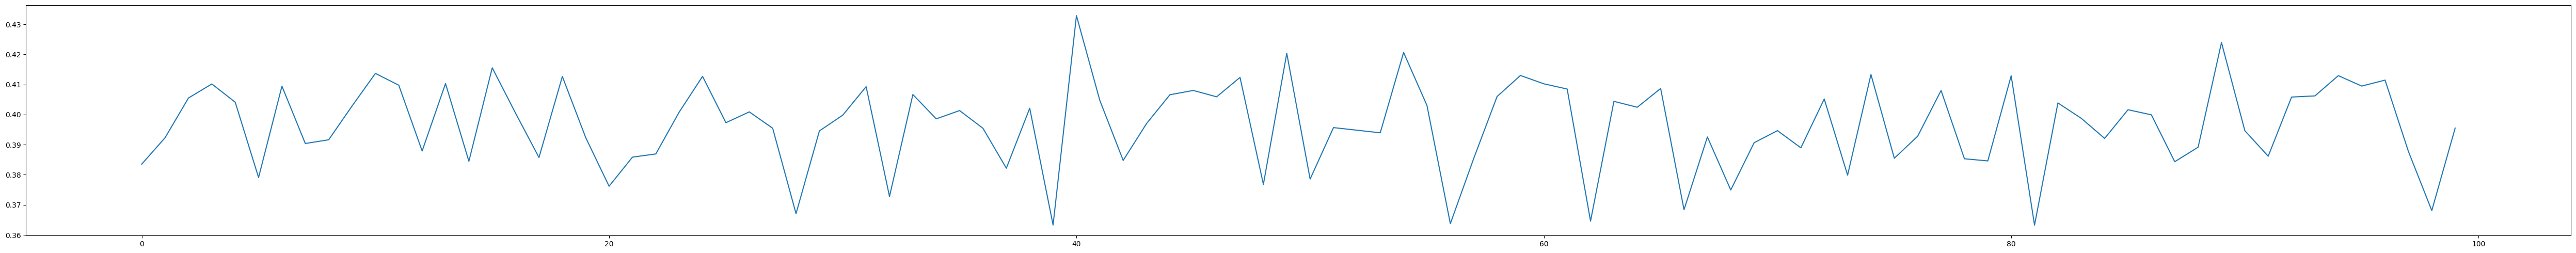

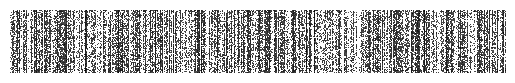

In [247]:
i_T, i_OST = infer(input=images[1], W=W, iter_cnt=iter_cnt)

print(f'{i_T[-1]=}')
simple_plot(T=i_T)

show_image(image=i_OST, cmap='Greys')

[[ 0 98 97 ...  2  1  0]
 [98  0 98 ...  3  2  1]
 [97 98  0 ...  4  3  2]
 ...
 [ 2  3  4 ...  0 98 97]
 [ 1  2  3 ... 98  0 98]
 [ 0  1  2 ... 97 98  0]]


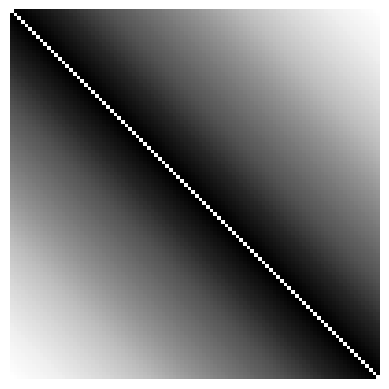

In [248]:
a = get_discount_matrix(100)
2 * a
print(a)
show_image(a, cmap='Greys')